In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset

plt.style.use('ggplot')

import nltk
from nltk.stem import WordNetLemmatizer
from copy import deepcopy

from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm ## to add progress bars to loops and iterations

import time

In [2]:
# download dataset from hungging face
dataset = load_dataset("tweet_eval", "sentiment")

dataset

Found cached dataset tweet_eval (C:/Users/Splute/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 45615
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 12284
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [3]:
data_test = pd.DataFrame(dataset['test'])

# Balance the amount of each class
SEED = 66
num_test_per_class = 2000
balanced_test_data = data_test.groupby('label', group_keys=False).apply(lambda x:\
        x.sample(min(len(x), num_test_per_class), random_state=SEED)).sample(frac=1, random_state=SEED)
# X_test = balanced_test_data.text.tolist()

balanced_test_data.head()
# X_test.label.value_counts()

,text,label
1077,Wait till this guy finds out Trump cut his Med...,0
9061,"@user Have a listen, these are the feelings of...",0
8577,The best #BlackFriday purchase! #TheWalkingDea...,2
11261,#Westworld is the greatest work of art I've ev...,2
8938,Barak Obama | highlighting the many broken pro...,0


In [4]:
df = balanced_test_data
y_test = df['label'].to_numpy().astype(int)
y_test[:5]
# # 添加一个新的整数索引，并将其保存为'id'列
# df['id'] = df.reset_index(drop=True).index
# # 将'id'列移动到最左边
# id_column = df['id']  # 获取'id'列
# df.drop(columns=['id'], inplace=True)  # 删除'id'列
# df.insert(0, 'id', id_column)  # 将'id'列插入到第一列
# df

array([0, 0, 2, 2, 0])

In [6]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    
    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

## Test of VADER

In [7]:
sia = SentimentIntensityAnalyzer()

In [8]:
test = sia.polarity_scores('I am very happy')
print(test)

{'neg': 0.0, 'neu': 0.429, 'pos': 0.571, 'compound': 0.6115}


In [11]:
vader_res = []
start_time = time.time()
for _, row in tqdm(df.iterrows(), total=len(df)):
    text = row['text']
    res = sia.polarity_scores(text)
    compound_score = res['compound']
    # 根据'compound'得分返回整数标签
    if compound_score >= 0.35:
        label = 2  # 正面情感
    elif compound_score <= -0.35:
        label = 0  # 负面情感
    else:
        label = 1  # 中性情感
    vader_res.append(label)
    # break
elapsed_time = time.time() - start_time

print(classification_report(y_test, vader_res))
print("Time: {:.3f}s".format(elapsed_time))

    

  0%|          | 0/6000 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.71      0.43      0.53      2000
           1       0.46      0.63      0.53      2000
           2       0.62      0.64      0.63      2000

    accuracy                           0.57      6000
   macro avg       0.60      0.57      0.57      6000
weighted avg       0.60      0.57      0.57      6000

Time: 0.962s


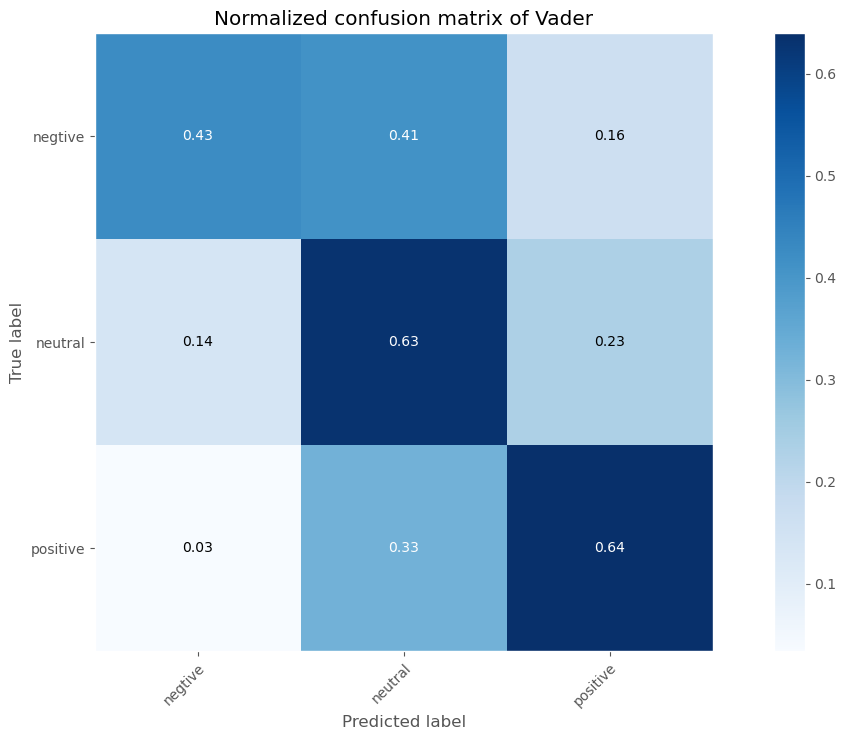

In [13]:
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, vader_res, classes=['negtive','neutral','positive'], normalize=True, title='Normalized confusion matrix of Vader')
plt.show()

## Text of roBerta

In [14]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [15]:
MODEL = f"cardiffnlp/twitter-xlm-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [16]:
example = 'How would you feel, if I... if I gave you your copy in person?'
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores.argmax()

1

In [17]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    label = scores.argmax()

    return label

In [18]:
# run on the entire dataset
roBerta_res = []
start_time = time.time()
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['text']
    res = polarity_scores_roberta(text)
    roBerta_res.append(res)

elapsed_time = time.time() - start_time

print(classification_report(y_test, roBerta_res))
print("Time: {:.3f}s".format(elapsed_time))

  0%|          | 0/6000 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.68      0.87      0.77      2000
           1       0.62      0.55      0.58      2000
           2       0.84      0.70      0.77      2000

    accuracy                           0.71      6000
   macro avg       0.71      0.71      0.70      6000
weighted avg       0.71      0.71      0.70      6000

Time: 407.003s


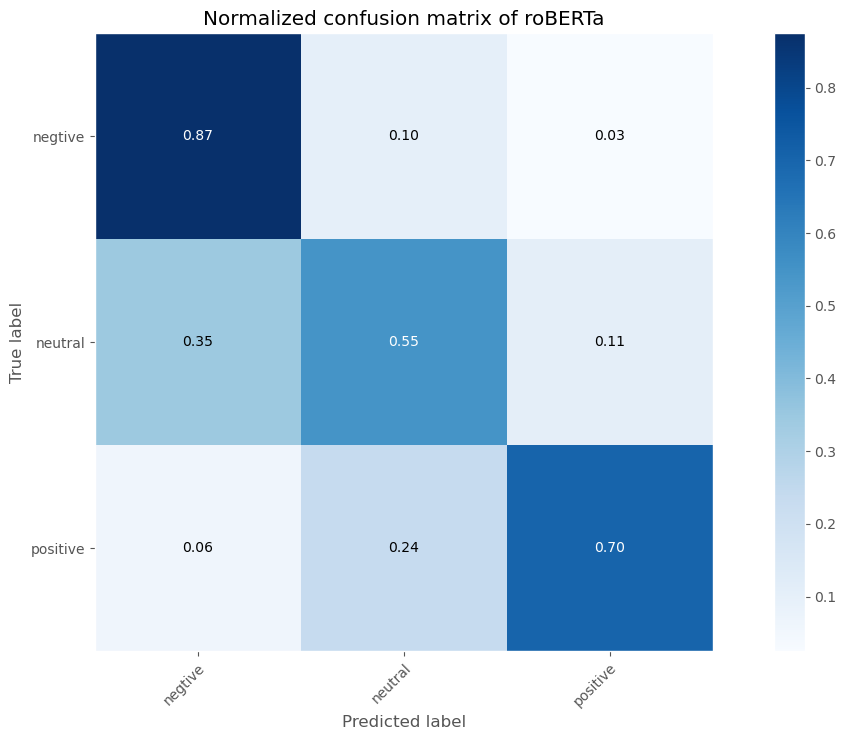

In [19]:
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, roBerta_res, classes=['negtive','neutral','positive'], normalize=True, title='Normalized confusion matrix of roBERTa')
plt.show()

## Test of BiLSTM

In [20]:
# import word vectors

words = dict()
wird_filepath = 'embeddings\glove.twitter.27B\glove.twitter.27B.100d.txt'

def add_to_dict(d, filename):
    with open(filename, 'r') as f:
        for line in f.readlines():
            line = line.split(' ')

            try:
                d[line[0]] = np.array(line[1:],dtype=float)
            except:
                continue

add_to_dict(words, wird_filepath)

In [21]:
len(words)

1193514

In [22]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Splute\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [23]:
# Use regular expressions to define word segmentation rules,
# and split text according to patterns that match regular expressions
tokenizer = nltk.RegexpTokenizer(r"\w+")

# find the root-word
lemmatizer = WordNetLemmatizer()

lemmatizer.lemmatize('feet')

# preprocess
def msg_to_token_list(string):
    tokens = tokenizer.tokenize(string)
    lowercased_tokens = [token.lower() for token in tokens]
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in lowercased_tokens]
    useful_tokens = [token for token in lemmatized_tokens if token in words]

    return useful_tokens

In [24]:
def msg_to_word_vectors(msg, word_dict = words):
    processed_list_tokens = msg_to_token_list(msg)

    vectors = []

    for token in processed_list_tokens:
        if token not in word_dict:
            continue

        token_vector = word_dict[token]
        vectors.append(token_vector)

    return np.array(vectors, dtype=float)

In [25]:
msg_to_word_vectors('@#Did you feel happy?').shape


(4, 100)

In [26]:
# get x and y
def dff_to_X_y(dff):
    y = dff['label'].to_numpy().astype(int)

    all_word_vector_sequences = []

    for msg in dff['text']:
        msg_as_vector_seq = msg_to_word_vectors(msg)

        if msg_as_vector_seq.shape[0] == 0:
            msg_as_vector_seq = np.zeros(shape=(1,100))

        all_word_vector_sequences.append(msg_as_vector_seq)

    return all_word_vector_sequences, y


In [27]:
def pad_X(X, desired_sequence_length = 38):
    X_copy = deepcopy(X) # create a totally new copy

    for i, x in enumerate(X):
        x_seq_len = x.shape[0]
        sequence_length_difference = desired_sequence_length - x_seq_len

        pad = np.zeros(shape=(sequence_length_difference, 100))

        X_copy[i] = np.concatenate([x,pad])

    return np.array(X_copy).astype(float)

In [28]:
X_test, y_test = dff_to_X_y(df)
X_test = pad_X(X_test)

X_test.shape,y_test.shape

((6000, 38, 100), (6000,))

In [29]:
best_model = load_model('models/GloVe_LSTM')

start_time = time.time()
predictions = best_model.predict(X_test)
biLSTM_res = []
for pred in predictions:
  biLSTM_res.append(pred.argmax())

elapsed_time = time.time() - start_time

print(classification_report(y_test, biLSTM_res))
print("Time: {:.3f}s".format(elapsed_time))

              precision    recall  f1-score   support

           0       0.71      0.63      0.67      2000
           1       0.51      0.65      0.57      2000
           2       0.75      0.65      0.70      2000

    accuracy                           0.64      6000
   macro avg       0.66      0.64      0.64      6000
weighted avg       0.66      0.64      0.64      6000

Time: 8.572s


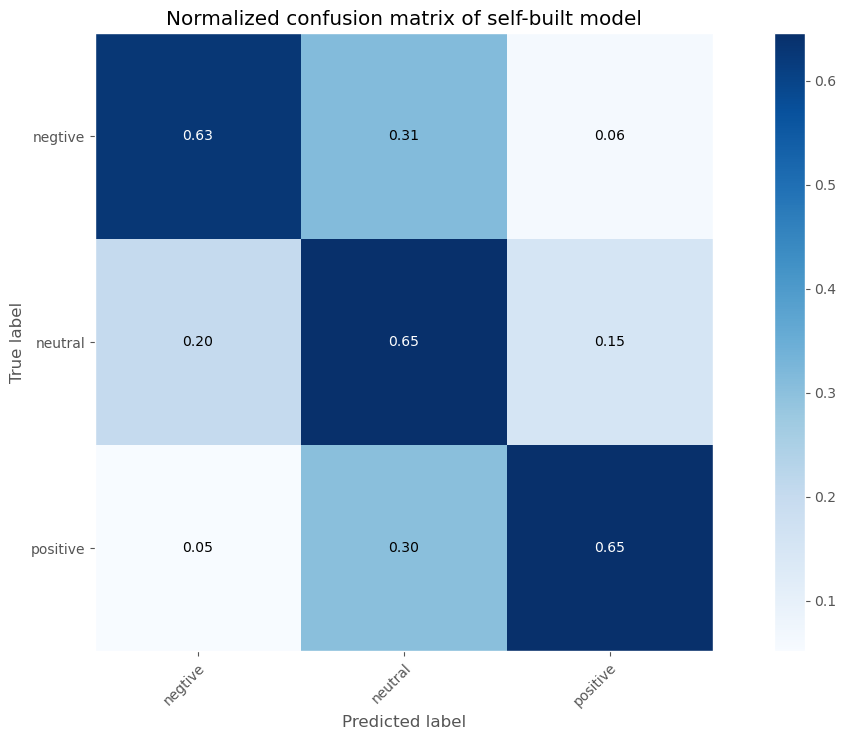

In [30]:
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, biLSTM_res, classes=['negtive','neutral','positive'], normalize=True, title='Normalized confusion matrix of self-built model')
plt.show()

## The end